In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv
import json

# math packages:
import pandas as pd
import numpy as np
from scipy import stats

import datetime as dt 
from scipy.stats import kendalltau, pearsonr, spearmanr
import math
from scipy.stats import gamma
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import bernoulli
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.distributions.empirical_distribution import ECDF
# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import display, Markdown, Latex, HTML
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Colormap

# mapping
import geopandas as gpd

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac

# documenting
from IPython.display import Markdown as md


# returns the p_value for each test
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
xlab_k = {'labelpad':10, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}


# # use these to format date axis in charts
# weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
# # onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
# # everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

# months = mdates.MonthLocator(bymonth=[3,6,9,12])
# bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
# allmonths = mdates.MonthLocator()
# wks_fmt = mdates.DateFormatter('%d')
# mths_fmt = mdates.DateFormatter('%b')

# map marker size:
markerSize = 100
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

In [2]:
# set some parameters:
start_date = '2020-04-01'
end_date ='2021-04-01'

startyearmonth = '{}/{}'.format(start_date[5:7], start_date[:4])
endyearmonth = '{}/{}'.format(end_date[5:7], end_date[:4]) 

# decide which data to use
aggregated = False


# collect the names:
# group_names = list(these_groups.keys())

# choose a lake:
# lake = 'Lac Léman'
coi = 'Neuchâtel'
bassin_label = 'Aare'
bassin = ['Aare', 'Aare|Nidau-Büren-Kanal','Schüss', 'Neuenburgersee', 'Thunersee','Bielersee', 'Brienzersee','La Thièle']
bassin_lmn = ['Rhône', 'Lac Léman']
samples_all = 'All samples'
# lavey_locs= ['lavey-les-bains-2','lavey-les-bains', 'lavey-la-source']


# define a significant event:
sig = .9
one_minus_sig = (1-sig)

# define explanatory variables:
expv = ['population','streets','buildings','rivs']

# name the folder:
name_of_project = 'bielsummary'
save_output = False

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# get the data
# aggregated survey data
# dfAgg = pd.read_csv(F"{survey_data}/results_with_zeroes_aggregated_parent.csv")

# keep track of output
files_generated = []
figure_num = 1
data_num = 1

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

In [3]:
# non aggregated survey data
# Zero values are assigned for all codes not identified at a survey, for each survey
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")

# house keeping
dfSurveys = dfSurveys[(dfSurveys.date >= start_date)&(dfSurveys.date <= end_date)]
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'], format="%Y-%m-%d")

In [4]:
# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)
dfBeaches.rename(columns={"NUMPOINTS":"intersects"}, inplace=True)

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')

# dimensional data
dfDims = pd.read_csv(F"{survey_data}/dims_data.csv")

# project lakes and beaches:

with open(F"{location_data}/project_lakes.json", "r") as a_file:
    project_lakes = json.load(a_file)
with open(F"{location_data}/project_beaches.json", "r") as a_file:
    project_beaches = json.load(a_file)
    
print(F"\nThese are the project beaches:\n\n{project_beaches}\n")
print(F"\nThese are the project lakes:\n\n{project_lakes}\n")


These are the project beaches:

['neuenburgersee_cudrefin_mattera', 'la-petite-plage', 'evole-plage', 'plage-de-cheyres', 'mullermatte', 'bielersee_vinelz_fankhausers', 'baby-plage-geneva', 'baye-de-montreux-g', 'grand-clos', 'preverenges', 'quai-maria-belgia', 'zurichsee_wollishofen_langendorfm', 'zurichsee_kusnachterhorn_thirkell-whitej', 'zuerichsee_richterswil_benkoem_2', 'rastplatz-stampf', 'weissenau-neuhaus', 'thunersee_spiez_meierd_1', 'walensee_walenstadt_wysse', 'gasi-strand', 'vira-gambarogno', 'sentiero-giro-del-golf-spiaggia', 'maladaire']


These are the project lakes:

['Bielersee', 'Walensee', 'Zurichsee', 'Lac Léman', 'Thunersee', 'Neuenburgersee', 'Lago Maggiore']



In [5]:
group_names_locations = {
    "waste water": "wastewater.json" ,
    "less than 5mm":"codeListMicros.json",
    "construction":"construction.json",
    "food":"foodstuff.json",
    "agg-con-trans":"cat.json",
    "agriculture":"ag.json",
    "tobacco":"tobac.json",
    "recreation":"recreation.json",    
    "packaging":"packaging.json",
    "personal items":"pi.json",    
}


frag_plas = {"fragmented plastics":["G79", "G78", "G75"]}
levels={'muni':coi, 'catchment':bassin_label}

these_cols = ['loc_date', 'location', 'water_name','type', 'date']
catchment_cols = ['region','water_name','type','city','loc_date', 'location', 'date']

# the foam codes are automatically aggregated to the parent code for all data
foams={'G82':['G82', 'G912'], 'G81':['G81', 'G911'], 'G74':['G74', 'G910', 'G909']}

In [6]:
# make a copy of the survye data and tag the records as either lake or river:
data = dfSurveys.copy()

# map lake or river from dfBeaches
lakes = dfBeaches[dfBeaches.water == 'l'].water_name.unique()
rivers = dfBeaches[dfBeaches.water == 'r'].water_name.unique()

# map values to new column t:
data['type'] = 't'
for a_place in data.water_name.unique():
    data.loc[data.water_name.isin(lakes), 'type'] = 'l'
    data.loc[data.water_name.isin(rivers), 'type'] = 'r'

# check if there any un categorized records:

print(F"\nThere are {len(data[data['type']=='t'])} records that were not classified as either lake or river:\n\n{data[data['type']=='t']}\n")


There are 0 records that were not classified as either lake or river:

Empty DataFrame
Columns: [date, code, pcs_m, quantity, location, loc_date, water_name, type]
Index: []



## <span style="color:#008891">For all records: aggregate foam values, add explanatory variables to survey records, aggregate survey totals:</span>

In [7]:
# data.reset_index(inplace=True)

a_class_kwargs = dict(
    code_group_data=group_names_locations,
    new_code_group=frag_plas,
    levels=levels,
    code_group_loc=output,
    these_cols=these_cols,
    foams=foams
)
a = ac.PreprocessData(data, dfBeaches,**a_class_kwargs)


code maps done
made code groups
making group map
agg foams complet
added exp vs
assigned results to code groups


In [8]:
#the top ten codes by quantity from all the survey data
a_data = a.survey_data.copy()

In [9]:
print(F"There are { len(a.daily_totals_all)} surveys and {'{:,}'.format(len(a_data))} rows/observations.\n\nThe median pieces/meter per survey is {np.round(a.median_daily_total, 2)}")

There are 346 surveys and 76,466 rows/observations.

The median pieces/meter per survey is 1.98


### <span style="color:#008891">Aggregate the foam values and group surveys according to use or type. All locations included</span>

In [10]:
with open(F"{code_defs}/all_foams.json", "r") as a_file:
    foams_bg = json.load(a_file)
with open(F"{code_defs}/sheeting.json", "r") as a_file:
    sheeting_bg = json.load(a_file)
with open(F"{code_defs}/fragmented_plastics.json", "r") as a_file:
    fragplas_bg = json.load(a_file)

In [11]:
a_data.columns

Index(['date', 'code', 'pcs_m', 'quantity', 'location', 'loc_date',
       'water_name', 'type', 'groupname', 'population', 'string_date'],
      dtype='object')

In [12]:
the_big_group = ['G27','G30', *foams_bg, *sheeting_bg, *fragplas_bg]

# map codes to descriptions to:
material_map = dfCodes.material
desc_map = dfCodes.description

# make an intermediary group
a_data['big_group'] = 'no group'
a_data.loc[a_data.code.isin(foams_bg), 'big_group'] = 'foams'
a_data.loc[a_data.code.isin(sheeting_bg), 'big_group'] = 'sheeting'
a_data.loc[a_data.code.isin(fragplas_bg), 'big_group'] = 'frag plastic'
a_data.loc[a_data.code.isin(['G27']), 'big_group'] = 'cigarette ends'
a_data.loc[a_data.code.isin(['G30']), 'big_group'] = 'snack wrapper'
a_data.loc[~a_data.code.isin(the_big_group), 'big_group'] = 'other'

# note all records where quantity is > 0
a_data['found'] = a_data.quantity > 0

In [13]:

# get the list of codes by quantity
national_topten= a.code_totals.sort_values(ascending=False)

# take first ten records after sorting
national_topten_codes = national_topten.index[:10]

# grab the data from the survey results:
top_ten_national = a_data[a_data.code.isin(national_topten_codes)][['code', 'big_group', 'groupname','quantity', 'found', 'pcs_m', 'loc_date']].copy()

top_ten_national['material'] = top_ten_national.code.map(lambda x: material_map.loc[x])
top_ten_national['description'] = top_ten_national.code.map(lambda x: desc_map.loc[x])

# agg the values from the survey data:
top_ten_agg = top_ten_national.groupby(['code', 'description', 'big_group', 'groupname', 'material'], as_index=False).agg({'pcs_m':'mean', 'quantity':'sum', 'found':'sum', 'loc_date':'nunique'})

# calculate the find rate and % of total for each code:
top_ten_agg['find rate'] = top_ten_agg.found/top_ten_agg.loc_date
top_ten_agg['% of total'] = top_ten_agg.quantity/a_data.quantity.sum()

# for display purposes make the description the index
top_ten_agg.set_index('description', inplace=True)

print(F"\nthe top ten codes from all survey data, by quantity:\n\n")
top_ten_agg[['big_group','groupname', 'quantity', '% of total', 'find rate', 'pcs_m']].sort_values(by='quantity', ascending=False).round(2)




the top ten codes from all survey data, by quantity:




,big_group,groupname,quantity,% of total,find rate,pcs_m
description,,,,,,
Cigarette butts and filters,cigarette ends,tobacco,7471,0.15,0.87,0.53
Foamed polystyrene pieces 0.5cm - 2.5cm,foams,construction,3616,0.07,0.57,0.33
Plastic pieces 0.5cm - 2.5cm,frag plastic,fragmented plastics,3419,0.07,0.70,0.28
"Food wrappers; candy, snack packaging",snack wrapper,food,3070,0.06,0.85,0.25
Plastic pieces 2.5cm - 50cm,frag plastic,fragmented plastics,2882,0.06,0.80,0.23
Industrial sheeting,sheeting,agg-con-trans,2366,0.05,0.70,0.20
"Glass or ceramic drink bottles, pieces",other,food,1821,0.04,0.64,0.16
Foam polystyrene; expanded beads/balls 2.5cm - 50cm,foams,construction,1706,0.03,0.52,0.14
Industrial pellets (nurdles),frag plastic,less than 5mm,1664,0.03,0.32,0.13


#### <span style="color:#008891">Aggregate the survey results to the groupname for each survey. All locations included</span>

In [14]:
# calculate the fail rates at this aggregation level
group_fail_rates = a_data.groupby(['loc_date', 'groupname'], as_index=False).quantity.sum()
group_fail_rates['found'] = group_fail_rates.quantity > 0 
group_fail_rates = group_fail_rates.groupby('groupname').found.sum()

In [15]:
group_summary = a_data.groupby('groupname').agg({'pcs_m':'mean', 'quantity':'sum',  'loc_date':'nunique'})
group_summary['found'] = group_summary.index.map(lambda x:group_fail_rates.loc[x] )
group_summary['find rate'] = group_summary.found/group_summary.loc_date

print("\nThis is the survey results aggregated to groupname for each survey:\n\n")
group_summary.round(2)


This is the survey results aggregated to groupname for each survey:




,pcs_m,quantity,loc_date,found,find rate
groupname,,,,,
agg-con-trans,0.02,2869,346,267,0.77
agriculture,0.00,179,346,65,0.19
construction,0.03,9017,346,315,0.91
food,0.03,9210,346,337,0.97
fragmented plastics,0.20,6749,346,297,0.86
less than 5mm,0.02,3893,346,178,0.51
packaging,0.01,1995,346,273,0.79
personal items,0.00,1176,346,252,0.73
recreation,0.01,2314,346,293,0.85


#### <span style="color:#008891">Aggregate the survey results to the water feature by groupname for each survey</span>

In [56]:

# initial aggrgation for this level:
feature_group_summary = a_data[a_data.water_name.isin(project_lakes)].groupby(['water_name','loc_date', 'groupname'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
fgs_total = feature_group_summary.groupby('water_name').quantity.sum()

# get the number of failures at this level
feature_group_summary['found'] = feature_group_summary.quantity > 0

# sum up failures, tries and quantity, get the mean value for pcs_m
fgs = feature_group_summary.groupby(['water_name', 'groupname'], as_index=False).agg({'pcs_m':'mean', 'quantity':'sum', 'loc_date':'nunique', 'found':'sum'})

# get some rates
fgs['find rate'] = fgs.found/fgs.loc_date
fgs['feature_total'] = fgs.water_name.map(lambda x: fgs_total.loc[x])
fgs['% of total'] = fgs.quantity/fgs.feature_total
fgs['rating'] = fgs['% of total']+fgs['pcs_m']+fgs['find rate']


print("\nThis is the survey results aggregated to groupname for each survey on Bielersee:\n\n")
fgs_rating = fgs[['water_name','groupname','% of total']].round(2).pivot(index='groupname', columns='water_name')
fgs_rating.columns = fgs_rating.columns.get_level_values(1)
fgs_rating


This is the survey results aggregated to groupname for each survey on Bielersee:




water_name,Bielersee,Lac Léman,Lago Maggiore,Neuenburgersee,Thunersee,Walensee,Zurichsee
groupname,,,,,,,
agg-con-trans,0.08,0.05,0.04,0.03,0.10,0.09,0.03
agriculture,0.00,0.00,0.00,0.00,0.00,0.01,0.00
construction,0.10,0.22,0.26,0.13,0.17,0.26,0.07
food,0.19,0.17,0.19,0.21,0.16,0.13,0.27
fragmented plastics,0.16,0.15,0.12,0.14,0.13,0.12,0.08
less than 5mm,0.05,0.11,0.04,0.06,0.02,0.05,0.02
packaging,0.06,0.03,0.03,0.05,0.05,0.03,0.06
personal items,0.02,0.02,0.03,0.03,0.02,0.02,0.05
recreation,0.08,0.04,0.03,0.04,0.05,0.04,0.06


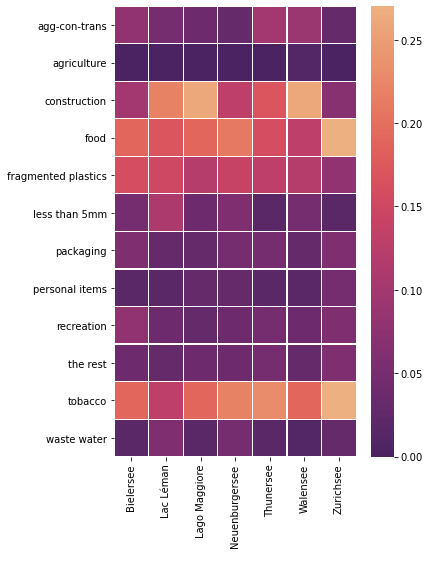

In [60]:
fig, ax = plt.subplots(figsize=(6,8))
sns.heatmap(data=fgs_rating, ax = ax, cmap='flare_r', linewidth=.05, linecolor='white')

ax.set_ylabel("")
ax.set_xlabel(" ")

plt.tight_layout()

plt.show()
plt.close()

#### <span style="color:#008891">The top ten results for each water feature</span>

In [48]:
feature_topten_summary = a_data.groupby(['water_name','code'], as_index=False).agg({'pcs_m':'mean', 'quantity':'sum', 'found':'sum', 'loc_date':'nunique'})
fts_code_t = feature_topten_summary.groupby('water_name').quantity.sum()
fts=feature_topten_summary.copy()

fts['feature_total'] = fts.water_name.map(lambda x: fts_code_t.loc[x])
fts['find rate'] = fts.found/fts.loc_date
fts['% of total'] = fts.quantity/fts.feature_total
fts['rating'] = fts['% of total']+fts['pcs_m']+fts['find rate']
fts['description'] = fts.code.map(lambda x: desc_map.loc[x])
fts['rating'] = fts['% of total']+fts['pcs_m']+fts['find rate']
fts.set_index('description', inplace=True)

fts[fts.water_name=='Bielersee'][['quantity', '% of total', 'find rate', 'pcs_m', 'rating']].sort_values(by='quantity', ascending=False)[:10].round(2)

,quantity,% of total,find rate,pcs_m,rating
description,,,,,
Cigarette butts and filters,719,0.16,0.78,0.54,1.49
Plastic pieces 0.5cm - 2.5cm,371,0.08,0.84,0.41,1.33
Plastic pieces 2.5cm - 50cm,334,0.08,0.89,0.37,1.34
"Food wrappers; candy, snack packaging",322,0.07,0.86,0.32,1.25
Industrial sheeting,300,0.07,0.92,0.39,1.37
"Glass or ceramic drink bottles, pieces",175,0.04,0.68,0.21,0.92
Packaging plastic nonfood or unknown,172,0.04,0.62,0.18,0.84
Foamed polystyrene pieces 0.5cm - 2.5cm,116,0.03,0.46,0.09,0.57
Foamed EVA (flexible plastic) for crafts & watersports,92,0.02,0.32,0.07,0.41


In [20]:
a_group_summary = a_data.groupby('groupname', as_index=False).agg({"quantity":"sum", "pcs_m":"mean"})
a_group_summary['% of total'] = a_group_summary.quantity/a_group_summary.quantity.sum()*100

a_group_summary.round(2)

,groupname,quantity,pcs_m,% of total
0,agg-con-trans,2869,0.02,5.75
1,agriculture,179,0.00,0.36
2,construction,9017,0.03,18.06
3,food,9210,0.03,18.45
4,fragmented plastics,6749,0.20,13.52
5,less than 5mm,3893,0.02,7.80
6,packaging,1995,0.01,4.00
7,personal items,1176,0.00,2.36
8,recreation,2314,0.01,4.64
9,the rest,1810,0.00,3.63


## <span style="color:#008891">For the catchment area: assign code groups, regional labels and daily totals for survey data from the catchment area:</span>

In [21]:

clas_kwargs = dict(
    code_group_data=group_names_locations,
    new_code_group=frag_plas,
    levels=levels,
    catchment_features=bassin,
    end_date=end_date,
    start_date=start_date,
    code_group_loc=output,
    catchment_cols=catchment_cols
)



b = ac.CatchmentArea(a.processed, dfBeaches, **clas_kwargs)

made code groups
making group map
assigned results to code groups
assigned regional labels
assigned results to code groups
assigned regional labels
made code totals
made code totals


In [22]:
som_bassin_data = b.bassin_data.copy()

# mark all the records that have quantity > 0
som_bassin_data['fail'] = som_bassin_data.quantity > 0
som_bassin_data = som_bassin_data[som_bassin_data.columns[1:]]
print(F"\nThe columns from the survey data:\n\n{som_bassin_data.columns}\n")


The columns from the survey data:

Index(['code', 'pcs_m', 'quantity', 'location', 'loc_date', 'water_name',
       'type', 'groupname', 'population', 'string_date', 'region', 'city',
       'fail'],
      dtype='object')



#### <span style="color:#008891">Get the dimensional data for the catchment area:</span>

In [23]:
# gather the dimensional data for this river basin
som_dims = dfDims.copy()

# the loc date key needs updateing:
som_dims['new_loc_date'] = list(zip(som_dims.location, som_dims.date))
som_dims = som_dims.loc[som_dims.new_loc_date.isin(som_bassin_data.loc_date.unique())]

# add travel and incidental time:
som_dims['total_time'] = som_dims.time_minutes+90
som_dims['total_time'] = som_dims.total_time/60
som_dims['total_time'] = som_dims.total_time.astype('int')

In [24]:
location_wname_key = dfBeaches[['water_name']]
som_dims['water_name'] = som_dims.location.map(lambda x: location_wname_key.loc[x][0])
print(F"\nThe columns from the dims data:\n\n{som_dims.columns}\n")


The columns from the dims data:

Index(['survey_key', 'date', 'length', 'area', 'mac_plast_w', 'mic_plas_w',
       'total_w', 'est_weight', 'num_parts_staff', 'num_parts_other',
       'time_minutes', 'participants', 'project', 'is_2020', 'location',
       'loc_date', 'new_loc_date', 'total_time', 'water_name'],
      dtype='object')



In [25]:
# dims data summary stats:
dims_summary_stats = som_dims.groupby('water_name').agg({'total_time':'sum', 'length':'sum', 'area':'sum', 'total_w':'sum', 'mac_plast_w':'sum'})
dims_summary_stats['mac_plast_w'] = dims_summary_stats.mac_plast_w/1000
print(F"\nThe time in minutes, cumulative meters surveyed, cumulative m² survyed, and the total weight of objects removed:\n\n{dims_summary_stats}\n")


The time in minutes, cumulative meters surveyed, cumulative m² survyed, and the total weight of objects removed:

                        total_time  length     area  total_w  mac_plast_w
water_name                                                               
Aare                            31     589   2543.0   13.136     5.255500
Aare|Nidau-Büren-Kanal           5     106    565.0    1.965     0.130000
Bielersee                      114    1124   5837.0   12.905     6.550000
Brienzersee                     16     230   1143.0    2.270     1.972120
La Thièle                        2      19     13.0    0.001     0.001000
Neuenburgersee                 132    3016  14328.0  225.447     8.501032
Schüss                           6      92    381.0    0.360     0.210000
Thunersee                       87    1939   8755.8   18.496     5.563550



### <span style="color:#008891"> Get sample rates at the code level:</span>

In [26]:
# map number of samples per location and sample total to each record

def add_attribute(x, a_map={}):
    try:
        num_samps = a_map[x]
    except:
        num_samps = 0
    return num_samps

# conut the number of samples per location
num_samp_location = b.bassin_pcsm_day.groupby('location').loc_date.count()

# retrieve the total quantity per sample
qty_sample = b.bassin_pcsm_day.groupby('loc_date').quantity.sum()

In [27]:
# map values to bassin data

# the number of samples at a location
for beach in som_bassin_data.location.unique():
    som_bassin_data.loc[som_bassin_data.location==beach, 'nsamps'] = add_attribute(beach, a_map=num_samp_location)

# the number of samples at a location divided by the total number of samples
# som_bassin_data['l_weight'] = som_bassin_data.nsamps/len(som_bassin_data.loc_date.unique())

# the survey total for the corresponding loc_date variable
for loc_date in som_bassin_data.loc_date.unique():
    som_bassin_data.loc[som_bassin_data.loc_date==loc_date, 'samp_total'] = qty_sample[[loc_date]][0]

# the % of total for that object for the survey defined by loc_date
som_bassin_data['sample_% _of_total'] = som_bassin_data.quantity/som_bassin_data.samp_total

In [28]:
def save_describe(x):
    data=x.describe()
    return data.values

# save the key values from the original data:
q_before = save_describe(som_bassin_data.quantity)
pc_befor = save_describe(som_bassin_data.pcs_m)
print(som_bassin_data.quantity.sum())

12646


In [29]:
# rank the quantity found of each code in each survey for all locations
ranked = []

# the loc_date values to aggregate:
locs = som_bassin_data.loc_date.unique()

# for each value in loc_date:
sbd = som_bassin_data.copy()
for a_samp in locs:
    # sort the values for each survey by 
    sbdl = sbd[sbd.loc_date == a_samp].sort_values(by='quantity', ascending=False)
    sbdl = sbdl.set_index(np.arange(1, len(sbdl)+1), drop=True)
    sbdl['sample_rank'] = sbdl.index
    ranked.append(sbdl)
    
# new data with amplitude rankings for each record
sbd = pd.concat(ranked, ignore_index=True)

# check the key values before and after:
print(q_before == sbd.quantity.describe().values)
print(sbd.quantity.sum())
print(pc_befor == sbd.pcs_m.describe().values)


[ True  True  True  True  True  True  True  True]
12646
[ True False  True  True  True  True  True  True]


In [30]:
sbd.columns

Index(['code', 'pcs_m', 'quantity', 'location', 'loc_date', 'water_name',
       'type', 'groupname', 'population', 'string_date', 'region', 'city',
       'fail', 'nsamps', 'samp_total', 'sample_% _of_total', 'sample_rank'],
      dtype='object')

In [31]:
sbd.head()

,code,pcs_m,quantity,location,loc_date,water_name,type,groupname,population,string_date,region,city,fail,nsamps,samp_total,sample_% _of_total,sample_rank
0,G27,0.25,20,weissenau-neuhaus,"(weissenau-neuhaus, 2021-02-07)",Thunersee,l,tobacco,5751.0,2021-02-07,Aare,Unterseen,True,10.0,79.0,0.253165,1
1,G67,0.15,12,weissenau-neuhaus,"(weissenau-neuhaus, 2021-02-07)",Thunersee,l,agg-con-trans,5751.0,2021-02-07,Aare,Unterseen,True,10.0,79.0,0.151899,2
2,G74,0.09,7,weissenau-neuhaus,"(weissenau-neuhaus, 2021-02-07)",Thunersee,l,construction,5751.0,2021-02-07,Aare,Unterseen,True,10.0,79.0,0.088608,3
3,G78,0.09,7,weissenau-neuhaus,"(weissenau-neuhaus, 2021-02-07)",Thunersee,l,fragmented plastics,5751.0,2021-02-07,Aare,Unterseen,True,10.0,79.0,0.088608,4
4,G81,0.07,6,weissenau-neuhaus,"(weissenau-neuhaus, 2021-02-07)",Thunersee,l,construction,5751.0,2021-02-07,Aare,Unterseen,True,10.0,79.0,0.075949,5


In [32]:
# the top ten for the catchment area:
catchment_top_ten = sbd.groupby('code').quantity.sum().sort_values(ascending=False)
print(F"\n objects grouped by code and sorted by quantity found:\n\n{catchment_top_ten[:10]}\n")


 objects grouped by code and sorted by quantity found:

code
G27     2352
G78      966
G79      833
G30      828
G67      765
G200     637
G81      550
G941     385
G117     279
G74      265
Name: quantity, dtype: int64



In [33]:
print("\n objects grouped by code and sorted by median pcs-m: \n\n")
sbd[sbd.quantity > 0].groupby(['code']).pcs_m.median().sort_values(ascending=False)[:10]


 objects grouped by code and sorted by median pcs-m: 




code
G122    0.580
G144    0.235
G27     0.185
G78     0.150
G119    0.135
G79     0.105
G67     0.090
G30     0.090
G5      0.090
G200    0.085
Name: pcs_m, dtype: float64

In [34]:
print("\n objects grouped by code and sorted by quantity found: \n\n")
sbd[sbd.quantity > 0].groupby(['code']).quantity.sum().sort_values(ascending=False)[:10]


 objects grouped by code and sorted by quantity found: 




code
G27     2352
G78      966
G79      833
G30      828
G67      765
G200     637
G81      550
G941     385
G117     279
G74      265
Name: quantity, dtype: int64

In [35]:
print("\n objects grouped by code and sorted by number of times at least one was found: \n\n")
sbd[sbd.quantity > 0].groupby(['code']).fail.sum().sort_values(ascending=False)[:10]


 objects grouped by code and sorted by number of times at least one was found: 




code
G27     106
G79     106
G30     104
G67      96
G78      95
G200     86
G81      71
G82      67
G89      63
G95      63
Name: fail, dtype: int64

### Sample rank: how much of the sample total was taken up by this object analogous to % of sample total

In [36]:
print("\n objects grouped by water feature and code, sorted by frequency of sample ranking: \n\n")
sbd[sbd.quantity > 0].groupby(['water_name','code', 'sample_rank'], as_index=False).loc_date.nunique().sort_values(by='loc_date', ascending=False)


 objects grouped by water feature and code, sorted by frequency of sample ranking: 




,water_name,code,sample_rank,loc_date
1397,Neuenburgersee,G27,1,22
2046,Thunersee,G27,1,11
1582,Neuenburgersee,G79,3,11
1296,Neuenburgersee,G200,2,10
485,Bielersee,G27,1,9
...,...,...,...,...
844,Bielersee,G929,28,1
843,Bielersee,G929,27,1
842,Bielersee,G928,42,1
841,Bielersee,G928,28,1


In [37]:
print("\n objects grouped by water feature and code, sorted by quantity found: \n\n")
sbd[sbd.quantity > 0].groupby(['water_name','code'], as_index=False).quantity.sum().sort_values(by='quantity', ascending=False)


 objects grouped by water feature and code, sorted by quantity found: 




,water_name,code,quantity
377,Neuenburgersee,G27,898
155,Bielersee,G27,719
537,Thunersee,G27,553
188,Bielersee,G78,371
189,Bielersee,G79,334
...,...,...,...
306,La Thièle,G67,1
307,La Thièle,G81,1
308,La Thièle,G82,1
313,Neuenburgersee,G103,1


In [38]:
print("\n objects grouped by water feature and code, sorted by median pcs_m: \n\n")
sbd[sbd.quantity > 0].groupby(['water_name','code'], as_index=False).pcs_m.median().sort_values(by='pcs_m', ascending=False)


 objects grouped by water feature and code, sorted by median pcs_m: 




,water_name,code,pcs_m
259,Brienzersee,G27,1.00
66,Aare,G98,0.97
278,Brienzersee,G78,0.61
144,Bielersee,G204,0.59
98,Bielersee,G122,0.58
...,...,...,...
435,Neuenburgersee,G930,0.01
436,Neuenburgersee,G931,0.01
354,Neuenburgersee,G182,0.01
510,Thunersee,G175,0.01


### Get sample rates at the group level:

In [39]:
def calculate_fail(x):
    a_q = x.sum()
    if a_q > 0:
        data = True
    else:
        data = False
    return data

In [40]:
sbd_g = sbd.groupby(['water_name', 'type', 'loc_date', 'date', 'location', 'groupname', 'nsamps', 'samp_total'], as_index=False).agg({'quantity':'sum', 'pcs_m':'sum', 'fail':calculate_fail})

sbd_g_ranked = []
for a_samp in locs:
    # sort the values for each survey by 
    sbdl = sbd_g.loc[sbd_g.loc_date==a_samp].sort_values(by='quantity', ascending=False)
    sbdl = sbdl.set_index(np.arange(1, len(sbdl)+1), drop=True)
    sbdl['sample_rank'] = sbdl.index
    sbd_g_ranked.append(sbdl)
sbd_g_ranked[0]
sbd_gr = pd.concat(sbd_g_ranked, ignore_index=True)
sbd_gr.head()

KeyError: 'date'

In [ ]:
fd = sbd_gr[(sbd_gr.water_name=='Bielersee')&(sbd_gr.sample_rank==1)].groupby('groupname').sample_rank.sum()
fd.sum()
print(fd)

In [ ]:
sbd_gr[sbd_gr.water_name == 'Aare'].groupby(['water_name','groupname', 'sample_rank'], as_index=False).loc_date.nunique()

In [ ]:
other_number_one_ranks = rank_and_code[rank_and_code['rank'] == 1].groupby(['code','location'], as_index=False).n_times.sum()
print(F"Codes and the number of times that they have been the number one item at a survey\n{other_number_one_ranks.groupby('code').n_times.sum().sort_values(ascending=False)}")

In [ ]:
# project directory is 'output/bielsummary'
sbd_ranked.to_csv(F"{project_directory}/aare_codes_ranked.csv")

In [ ]:
these_codes = ['G27', 'G30','G25', 'G81', 'G95', 'G67','G82']

In [ ]:
# grouped by survey and code group
sbd_ranked_gs = som_bassin_data.groupby(['loc_date','groupname','location', 'population'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

sbd_ranked_gs['% of total'] = sbd_ranked_gs.apply(lambda x: x.quantity/qty_sample[x.loc_date], axis=1)
# save the key values from the original data:
q_before = save_describe(sbd_ranked_gs.quantity)
pc_befor = save_describe(sbd_ranked_gs.pcs_m)
print(sbd_ranked_gs.quantity.sum())

In [ ]:
ranked = []
for a_samp in locs:
    sbdl = sbd_ranked_gs[sbd_ranked_gs.loc_date == a_samp].sort_values(by='% of total', ascending=False)
    sbdl = sbdl.set_index(np.arange(1, len(sbdl)+1), drop=True)
    sbdl['rank'] = sbdl.index
    ranked.append(sbdl)
    
sbd_ranked_gs = pd.concat(ranked, ignore_index=True)

# check the key values before and after:
print("Check that the survey values have not been altered:\n")
print(q_before == sbd_ranked_gs.quantity.describe().values)
print(pc_befor == sbd_ranked_gs.pcs_m.describe().values)

# check the % of total
print(F"\nCheck % of total: {sbd_ranked_gs.groupby('loc_date')['% of total'].sum().sum()}\n")
print(F"The number of SURVEYS where ALL TOBACCO items combined are rank one: {sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].loc_date.nunique()}\n")

print(F"All TOBACCO items combined were number one in {np.round((sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].loc_date.nunique()/sbd_ranked_gs.loc_date.nunique())*100,0)}% of the surveys.")
print(F"\nThe number of locations that tobaco is rank one: {sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].location.nunique()}\n")
print(F"The objects labeled tobacco:\n{sbd_ranked[sbd_ranked.groupname == 'tobacco'].code.unique()}")

In [ ]:
f = sbd_ranked_gs.groupby(['rank','groupname','location'], as_index=False).loc_date.nunique()
fx = f[f['rank'] == 1].groupby('groupname').loc_date.sum()
print(F"\nThe number of samples: {fx.sum()}\n")
print(F"Other groups and the number of times they have been the most prevalent item:\n{fx.sort_values(ascending=False)}\n")

In [ ]:
# get the pass fail rate for each water feature

# the total number of tries:
tries_t = som_bassin_data.groupby(['water_name', 'code']).loc_date.nunique()

# the total number of times that the object was found for a particular water feature
fails_b = som_bassin_data.groupby(['water_name','code']).fail.sum()

# the total number of samples:
n_samps_b = som_bassin_data.groupby(['water_name']).loc_date.nunique()

In [ ]:
# get all values greater than zero for each code and LOCATION
grtr_than_zero = som_bassin_data[(som_bassin_data.quantity > 0)].groupby(['code', 'location'], as_index=False).loc_date.count()

# weight the result by the sum of the loc_date column
grtr_than_zero['weight'] = grtr_than_zero.loc_date/grtr_than_zero.loc_date.sum()

# housekeeping
som_data = som_bassin_data.copy()

# get a list of the codes that were found at least once
codes_in_use = grtr_than_zero.code.unique()

In [ ]:
# combine the tries and fails dfs for each water feature
tries_fails_b = pd.concat([tries_t, fails_b], axis=1)
tries_fails_b.reset_index(inplace=True)

In [ ]:
tries_fails_b.iloc[:3]

In [ ]:
# get the ratio of total tries per code and location to total number of samples for that feature
for a_b in tries_fails_b.water_name.unique():
    tries_fails_b.loc[tries_fails_b.water_name==a_b, 'rate'] = tries_fails_b.fail/n_samps_b.loc[a_b]

tries_fails_b.iloc[:3]

In [ ]:
# the minimum rate is 1/ the current sample number + 1
# we are assuming that if the object has never been found before there
# is always a chance that we may find it on the next sample
# the longer we go without finding it the less likely it is to find in the river basin
# which means that once it has been identified this should be considered a significant event.
rate_min = 1/(len(a.processed.loc_date.unique())+1)
rate_min

In [ ]:
tries_fails_b.loc[tries_fails_b.fail==0, 'min_rate'] = rate_min
tries_fails_b.loc[tries_fails_b.fail>0, 'min_rate'] = tries_fails_b.rate
tries_fails_b.iloc[:3]

In [ ]:
# get the ratio samples-per-location/number-samples-catchment-area
weights = tries_fails_b[['water_name', 'loc_date']].drop_duplicates().set_index('water_name', drop=True)
weights['location_weight'] = weights.loc_date/len(locs)
nsamps = weights.loc['Aare', :]

# now the number of samples and the weight is available
nsamps

In [ ]:
# pull some samples from one river basin feature
feature = 'Aare'
n = weights.loc['Aare', 'loc_date']
rates = tries_fails_b.loc[tries_fails_b.water_name == 'Aare'][['code','min_rate']].set_index('code')

# store the samples here
theta_samples_feature = pd.DataFrame(index=codes_in_use)

In [ ]:
rates.loc['G27'].values

In [ ]:
# determine wehter or not an object was found at a survey
# use the rates for the parameter of a bernouli trial for each code

k=0
for j in np.arange(n):
    k+=1
    col_name = F"s_{int(k)}"
    for a_code in codes_in_use:
        theta_samples_feature.loc[a_code, col_name ] = bernoulli.rvs(rates.loc[a_code], size=1)


found_feature = theta_samples_feature > 0
codes_found_feature = [found_feature[found_feature[s_one] == True][s_one].index for s_one in found_feature.columns]
codes_found_len_feature = [len(x) for x in codes_found_feature]

In [ ]:
d_samps_aare = b.bassin_data[(b.bassin_data.quantity>0)&(b.bassin_data.water_name == "Aare")][['loc_date', 'code']].groupby('loc_date').code.unique().to_numpy()

In [ ]:
# get the number of times each code was found
def count_occurences(an_array):
    wiw = {}
    for a_list in an_array:
        for code in a_list:
            if code in wiw.keys():
                wiw[code] += 1
            else:
                wiw[code] = 1
    return [{'code':k, 'inst':v} for k,v in wiw.items()]
theta_codes_count = count_occurences(codes_found_feature)
dsamp_aare_count = pd.DataFrame(count_occurences(d_samps_aare)).set_index('code')

In [ ]:
dsamp_aare_count.loc['G7', 'inst']

In [ ]:
# combine the counts in to one dataframe and compare results

def combine_code_counts(x):
    try:
        data = dsamp_aare_count.loc[x, 'inst']
    except:
        data = 0
    return data
        
theta_codes = pd.DataFrame(theta_codes_count)
theta_codes['s_inst'] = theta_codes.code.map(lambda x: combine_code_counts(x))
theta_codes['inst_dif'] = theta_codes.inst - theta_codes.s_inst

# check the diffference between the two sets
print(theta_codes['s_inst'].sum())
print(theta_codes['inst'].sum())
print(theta_codes.inst_dif.sum())
print(len(theta_codes))

In [ ]:
theta_codes[theta_codes.code.isin([x for x in theta_codes.code.unique() if x not in dsamp_aare_count.index])]

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(12,8))
sns.barplot(data=theta_codes.sort_values(by='s_inst', ascending=False), x='code', y='s_inst', ax=axs[0])
sns.barplot(data=theta_codes.sort_values(by='inst', ascending=False), x='code', y='inst', ax=axs[1])
axs[0].tick_params(axis='x', labelrotation=90, labelsize=8)
axs[1].tick_params(axis='x', labelrotation=90, labelsize=8)
plt.show()
plt.close()

In [ ]:
theta_samples_all = pd.DataFrame(index=codes_in_use)
tries = som_bassin_data.groupby(['code']).loc_date.nunique()
fails = som_bassin_data.groupby('code').fail.sum()
# tries_fails by water body

# for one body of water
#fails_b = som_bassin_data.groupby(['water_name','code']).fail.sum()

tries_fails = pd.concat([tries, fails], axis=1)
tries_fails['rate'] = tries_fails.fail/tries_fails.loc_date

code_weights = grtr_than_zero.groupby('code').weight.sum()

In [ ]:
k = 0
for body in weights.index:
#     print(body)
#     print(tries_fails_b.loc[body].min_rate.sum())
    these_rates =tries_fails_b.loc[tries_fails_b.water_name == body][['code','min_rate']].set_index('code')
    

    for j in np.arange(weights.loc[body]['loc_date']):
        k+=1
        #print(j, k)
        col_name = F"s_{int(k)} {body}"
        for a_code in codes_in_use:
            theta_samples_all.loc[a_code, col_name ] = bernoulli.rvs(these_rates.loc[a_code], size=1)
#             theta_samples_all.loc[a_code, col_name ] = binom.rvs(1,these_rates.loc[a_code], size=1)
            

In [ ]:
found = theta_samples_all > 0
codes_found = [found[found[s_one] == True][s_one].index for s_one in found.columns]
codes_found_len = [len(x) for x in codes_found]

print(len(codes_found[0]))
print(codes_found_len[0])
print(len(codes_found))

In [ ]:
tries_fails.iloc[:3]

In [ ]:
# the number of unique codes per sample in the project data:
d_samps = b.bassin_data[b.bassin_data.quantity>0][['loc_date', 'code']].groupby('loc_date').code.nunique()

# the list of codes found at each survey in the project data:
d_samps_c = b.bassin_data[b.bassin_data.quantity>0][['loc_date', 'code']].groupby('loc_date').code.unique().to_numpy()

In [ ]:
def count_occurences(an_array):
    wiw = {}
    for a_list in an_array:
        for code in a_list:
            if code in wiw.keys():
                wiw[code] += 1
            else:
                wiw[code] = 1
    return [{'code':k, 'inst':v} for k,v in wiw.items()]
samp_codes = pd.DataFrame(count_occurences(d_samps_c)).set_index('code')


In [ ]:
# a_list_o_list = [value for k, value in samples.items()]
# the_list_o_list = [*a_list_o_list]
theta_codes = pd.DataFrame(count_occurences(codes_found))
theta_codes['s_inst'] = theta_codes.code.map(lambda x: samp_codes.loc[x, 'inst'])
theta_codes['inst_dif'] = theta_codes.inst - theta_codes.s_inst

In [ ]:
print(theta_codes['inst_dif'].sum())
print(len(theta_codes))
print(theta_codes.inst.sum(), theta_codes.s_inst.sum())

In [ ]:
fig, axs = plt.subplots(figsize=(18,8))
sns.barplot(data=theta_codes[theta_codes.inst >=20].sort_values(by='s_inst', ascending=False), x='code', y='s_inst', color='red', alpha=.6, ax=axs)
sns.barplot(data=theta_codes[theta_codes.inst >=20].sort_values(by='inst', ascending=False), x='code', y='inst', color='blue',alpha=.6, ax=axs)
axs.tick_params(axis='x', labelrotation=90, labelsize=10)
# axs[1].tick_params(axis='x', labelrotation=90, labelsize=8)
plt.show()
plt.close()

In [ ]:

fig, axs = plt.subplots(1,2)
sns.histplot(codes_found_len, ax=axs[0], binwidth=3)
sns.histplot(d_samps.values, ax=axs[1], binwidth=3)
plt.show()
plt.close()

In [ ]:
# found.rename(columns={x:x.split(" ")[-1] for x in found.columns}, inplace=True)
codes_found = [{'label':s_one.split(" ")[-1] , 'codes':found[found[s_one] == True][s_one].index.to_numpy()} for s_one in found.columns]
# codes_found_len = [len(x) for x in codes_found_feature]
a_label = codes_found[1]['label']
a_code = codes_found[1]['codes'][0]

In [ ]:
location_weight = som_bassin_data.groupby('water_name', as_index=False).l_weight.median()
location_weight.loc[4, 'water_name'] = "Thièle"

In [ ]:
agg_results_feature = som_bassin_data[som_bassin_data.pcs_m > 0].groupby(['water_name','code']).agg({'pcs_m':['mean', 'min', 'median', 'max']})
agg_results_feature.columns = agg_results_feature.columns.get_level_values(1)
agg_results_bassin = som_bassin_data[som_bassin_data.pcs_m > 0].groupby(['code']).agg({'pcs_m':['mean', 'min', 'median', 'max']})
agg_results_bassin.columns = agg_results_bassin.columns.get_level_values(1)
# get the parameters for one code at one sample:
this_data = agg_results_feature.loc[a_label,codes_found[1]['codes'][0]]
print(this_data['mean'])
print(codes_found[1]['codes'][0])
print(a_label)
loc = this_data['mean']
alpha=this_data['min']
beta = 1/alpha
print("\n the parameters \n")
print(loc, alpha, beta)

print("\nthe predicted result \n")
print(gamma.rvs(alpha, loc=loc, scale=beta))

In [ ]:
agg_results_feature.loc['Aare','G101']['min']

In [ ]:
# hmm = pd.DataFrame(codes_found).explode('codes').copy()
# hmm.drop_duplicates(inplace=True)
# print(hmm.isnull().values.any())
# hmm.reset_index(inplace=True, drop=True)

In [ ]:
def assign_params(a_label, a_code, a_param, params):
    default_params = agg_results_bassin
    try:
        this_param = params.loc[a_label,a_code][a_param]
    except:
        this_param = default_params.loc[a_code][a_param]
    return this_param
    

In [ ]:
o_samps_d = b.bassin_pcsm_day[['water_name', 'pcs_m']].sort_values(by='pcs_m')
o_samps_d.reset_index(inplace=True, drop=True)
o_samps_d

In [ ]:
location_weight.set_index('water_name', drop=True, inplace=True)


In [ ]:
location_weight

In [ ]:
sim_surveys = []
for i,sample in enumerate(codes_found):
    a_label = sample['label']
    som_codes = sample['codes']
    loc_weight = location_weight.loc[a_label]
    for a_code in som_codes:
        alpha = assign_params(a_label, a_code, 'median', agg_results_feature)
        loc = assign_params(a_label, a_code, 'min', agg_results_feature)
        scale = assign_params(a_label, a_code, 'max', agg_results_feature)+(5*alpha)       
        pcs_m = gamma.rvs(alpha+(loc_weight*alpha), loc=loc, scale=scale)
        sim_surveys.append({'code':a_code, 'label':a_label, 'survey':i, 'pcs_m':pcs_m})
    
new_surveys = pd.DataFrame(sim_surveys)
new_surveys_d = new_surveys.groupby(['survey','label'], as_index=False).pcs_m.sum().copy()

new_surveys_d.sort_values(by='pcs_m', inplace=True)
ns_d = new_surveys_d[['label', 'pcs_m']].reset_index(drop=True).copy()
ns_d.rename(columns={'label':'water_name'}, inplace=True)
ns_d['label'] = 'sim'
o_samps_d['label'] = 'odata'
o_samps_d['survey'] = o_samps_d.index
ns_d['survey'] =ns_d.index

In [ ]:
o_samps_d['label'] = 'odata'

combined = pd.concat([ns_d, o_samps_d])

In [ ]:
combined

In [ ]:
fig, axs = plt.subplots(figsize=(14,8))
sns.scatterplot(data=combined, x='survey', y='pcs_m', style='label', hue='water_name', palette='husl', s=40, ax=axs)
# sns.scatterplot(data=o_samps_d, x=o_samps_d.index, y=o_samps_d.pcs_m, hue=o_samps_d.water_name, palette='viridis', ax=axs)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

In [ ]:
# get the values for one survey:
fig, axs = plt.subplots(figsize=(14,8))
sns.boxplot(data=combined, x='water_name', y='pcs_m', hue='label', palette='flare', ax=axs, dodge=True)
sns.stripplot(data=combined, x='water_name', y='pcs_m', hue='label', palette='husl', ax=axs)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()


In [ ]:
hmm

In [ ]:
these_params = []

# get some paramaters from the data.
print("The codes and the number of samples that the parameters are being drawn from\n")
for code in samples[0]:
    samp_data = som_params[som_params.code == code].pcs_m
    # check how many samples there are for this region/district
    # if less than minsamps grab the results from the next highest level
    minsamps = 65
    if len(samp_data) < minsamps:
        samp_data = a.processed[(a.processed.code == code)&(a.processed.quantity > 0)].pcs_m
        loc = samp_data.min()
        alpha = samp_data.mean()
        scale = 1/alpha
    else:
        loc = samp_data.min()
        alpha = samp_data.mean()
        scale = 1/alpha
    print(code, len(samp_data))
    these_params.append(dict(code=code, loc=loc, alpha=alpha, scale=scale, data=samp_data))


In [ ]:
these_params[2]['data'].sum()

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch